In [1]:
import pandas as pd
import numpy as np

import scipy.stats as stats    #for plotting QQ plot.
 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

In [2]:
df = pd.read_csv('train.csv',usecols=['Age','Fare','Survived'])

In [3]:
df.sample(5)

,Survived,Age,Fare
117,0,29.0,21.0000
339,0,45.0,35.5000
441,0,20.0,9.5000
59,0,11.0,46.9000
146,1,27.0,7.7958


In [4]:
df.isnull().sum()

Survived      0
Age         177
Fare          0
dtype: int64

In [5]:
df['Age'].fillna(df['Age'].mean(),inplace=True)

In [6]:
X = df.iloc[:,1:]
y = df.iloc[:,0]

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

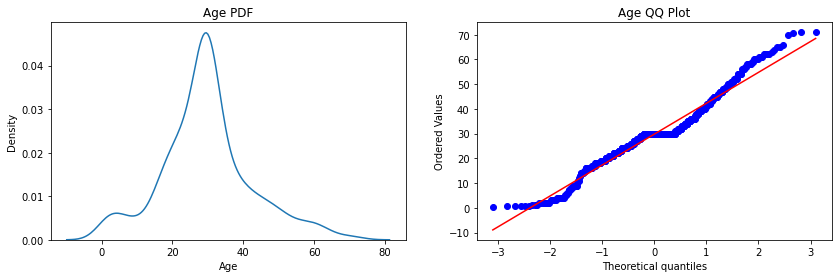

In [8]:
"""
Age is more or less normally distributed.
"""
plt.figure(figsize=(14,4))
plt.subplot(121)
sns.kdeplot(X_train['Age'])
plt.title('Age PDF')

plt.subplot(122)
stats.probplot(X_train['Age'], dist="norm", plot=plt)
plt.title('Age QQ Plot')

plt.show()

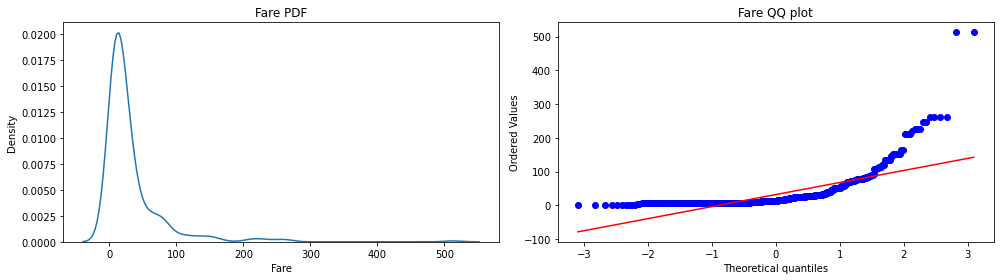

In [9]:
"""
Fare column is right skewed, so we need to apply log transformation to make this distribution normal.
"""

plt.figure(figsize=(14,4))
plt.subplot(121)
sns.kdeplot(X_train['Fare'])
plt.title('Fare PDF')

plt.subplot(122)
stats.probplot(X_train['Fare'],dist='norm',plot=plt)
plt.title('Fare QQ plot')
plt.tight_layout()
plt.show()

### Without Applying Function Transformer

In [10]:
clf1 = LogisticRegression()
clf2 = DecisionTreeClassifier()

In [11]:
clf1.fit(X_train,y_train)
clf2.fit(X_train,y_train)

y_pred1 = clf1.predict(X_test)
y_pred2 = clf2.predict(X_test)

In [12]:
print("Accuracy Log.Reg : ",accuracy_score(y_test,y_pred1))
print("Accuracy Dec.Tree : ",accuracy_score(y_test,y_pred2))

Accuracy Log.Reg :  0.6145251396648045
Accuracy Dec.Tree :  0.6145251396648045


### Applying Function Transformer

In [13]:
"""
Log of a negative number and zero is undefined. 
    np.log applies only log to the column. But it's shortcoming is that if there's a zero value it will give us error.
    np.log1p adds 1 to every value of the column and then apply log, so that there will be no zero in the column.
"""
trf = FunctionTransformer(func = np.log1p)

In [14]:
X_train_transformed = trf.fit_transform(X_train)
X_test_transformed =  trf.transform(X_test)

In [15]:
"""
Improvements in Logistic Regression is visible, whereas Decision Trees are not 
that much concerned about data's Distribution.
"""

clf1 = LogisticRegression()
clf2 = DecisionTreeClassifier()

clf1.fit(X_train_transformed,y_train)
clf2.fit(X_train_transformed,y_train)

y_pred1 = clf1.predict(X_test_transformed)
y_pred2 = clf2.predict(X_test_transformed)

print("Accuracy Log.Reg : ",accuracy_score(y_test,y_pred1))
print("Accuracy Dec.Tree : ",accuracy_score(y_test,y_pred2))

Accuracy Log.Reg :  0.6480446927374302
Accuracy Dec.Tree :  0.6145251396648045


### Using Cross Validation.

In [16]:
X_transformed = trf.fit_transform(X)

clf1 = LogisticRegression()
clf2 = DecisionTreeClassifier()

print("Log.Reg : ",np.mean(cross_val_score(clf1,X_transformed,y,scoring='accuracy',cv=10)))
print("Dec.Tree : ",np.mean(cross_val_score(clf2,X_transformed,y,scoring='accuracy',cv = 10)))

Log.Reg :  0.678027465667915
Dec.Tree :  0.6588264669163545


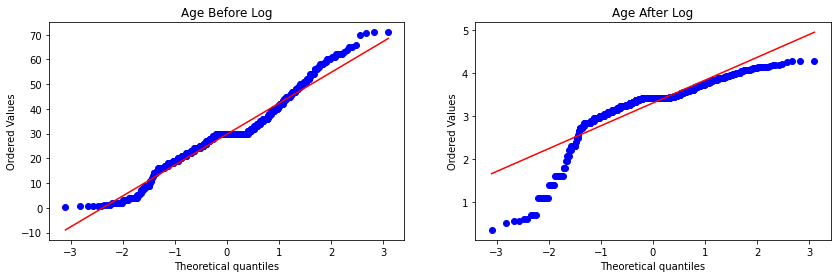

In [17]:
"""
Using log transformation on age column makes it worse.
"""

plt.figure(figsize=(14,4))

plt.subplot(121)
stats.probplot(X_train['Age'], dist="norm", plot=plt)
plt.title('Age Before Log')

plt.subplot(122)
stats.probplot(X_train_transformed['Age'], dist="norm", plot=plt)
plt.title('Age After Log')

plt.show()

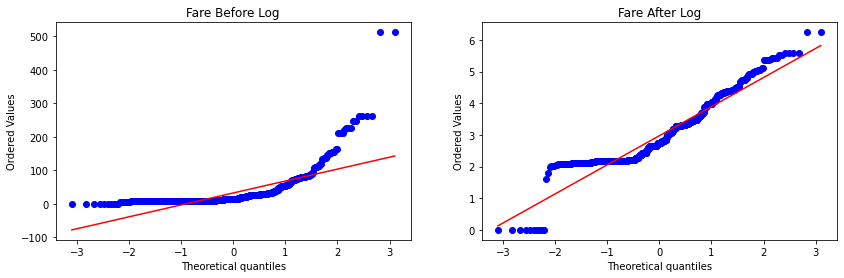

In [18]:
"""
Using log transformation on Fare column makes it better.
"""

plt.figure(figsize=(14,4))

plt.subplot(121)
stats.probplot(X_train['Fare'], dist="norm", plot=plt)
plt.title('Fare Before Log')

plt.subplot(122)
stats.probplot(X_train_transformed['Fare'], dist="norm", plot=plt)
plt.title('Fare After Log')

plt.show()

### We will apply transformation on Fare and leave Age alone.

In [19]:
trf2 = ColumnTransformer([
    ('log',FunctionTransformer(func=np.log1p),['Fare'])
],remainder='passthrough')

In [20]:
X_train_transformed2 = trf2.fit_transform(X_train)
X_test_transformed2 = trf2.transform(X_test)

In [21]:
clf1 = LogisticRegression()
clf2 = DecisionTreeClassifier()

clf1.fit(X_train_transformed2,y_train)
clf2.fit(X_train_transformed2,y_train)

y_pred1 = clf1.predict(X_test_transformed2)
y_pred2 = clf2.predict(X_test_transformed2)

print("Accuracy Log.Reg : ",accuracy_score(y_test,y_pred1))
print("Accuracy Dec.Tree : ",accuracy_score(y_test,y_pred2))

Accuracy Log.Reg :  0.6368715083798883
Accuracy Dec.Tree :  0.6145251396648045


In [22]:
X_transformed2 = trf2.fit_transform(X)

clf1 = LogisticRegression()
clf2 = DecisionTreeClassifier()

print("Log.Reg : ",np.mean(cross_val_score(clf1,X_transformed2,y,scoring='accuracy',cv=10)))
print("Dec.Tree : ",np.mean(cross_val_score(clf2,X_transformed2,y,scoring='accuracy',cv = 10)))

Log.Reg :  0.6712609238451936
Dec.Tree :  0.6610861423220974


### Creating a function 

In [23]:
def apply_transform(transform):
    X = df.iloc[:,1:3]
    y = df.iloc[:,0]
    
    trf = ColumnTransformer([('log',FunctionTransformer(transform),['Fare'])],remainder='passthrough')
    
    X_trans = trf.fit_transform(X)
    
    clf = LogisticRegression()
    
    print("Accuracy",np.mean(cross_val_score(clf,X_trans,y,scoring='accuracy',cv=10)))
    
    plt.figure(figsize=(14,4))

    plt.subplot(121)
    stats.probplot(X['Fare'], dist="norm", plot=plt)
    plt.title('Fare Before Transform')

    plt.subplot(122)
    stats.probplot(X_trans[:,0], dist="norm", plot=plt)
    plt.title('Fare After Transform')

    plt.show()

Accuracy 0.6195131086142323


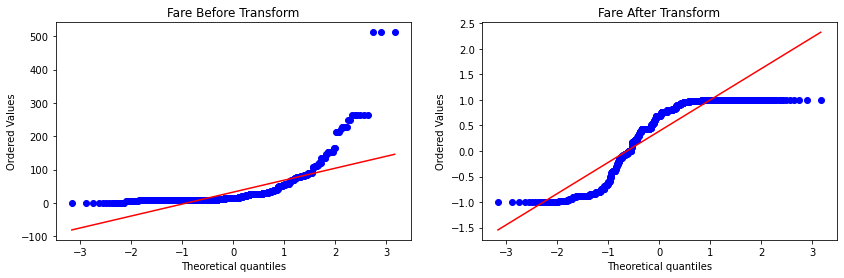

In [24]:
apply_transform(np.sin)

Accuracy 0.6589013732833957


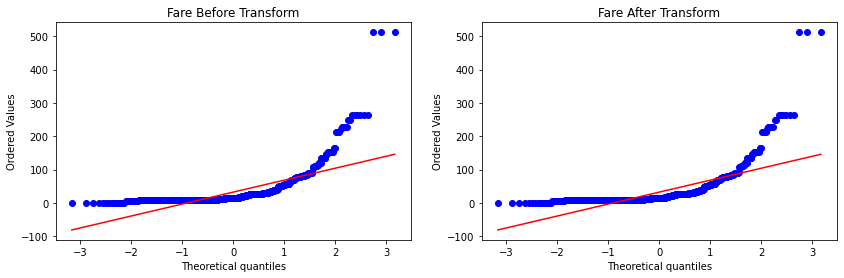

In [38]:
apply_transform(lambda x:x)

Accuracy 0.39843945068664166


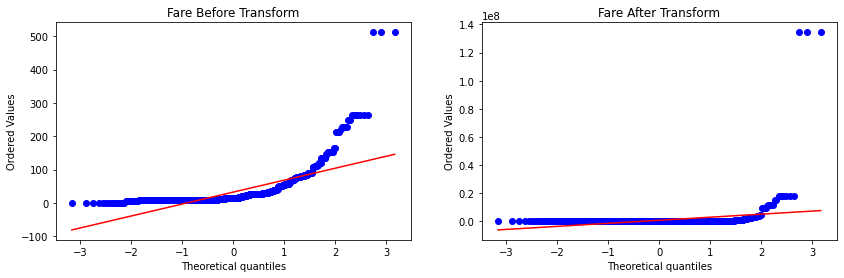

In [27]:
apply_transform(lambda x : x**3)

### Square Root

Accuracy 0.6611485642946316


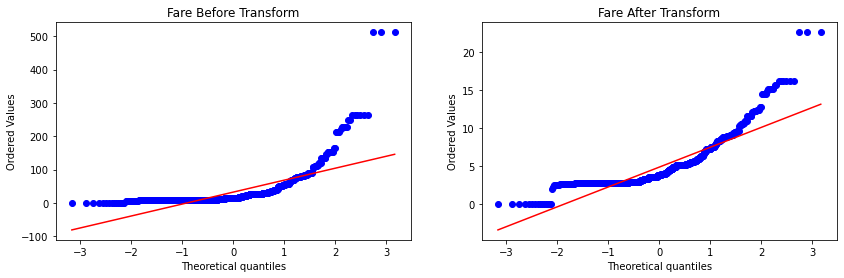

In [31]:
apply_transform(lambda x: x**(1/2))

### Reciprocal

Accuracy 0.61729088639201


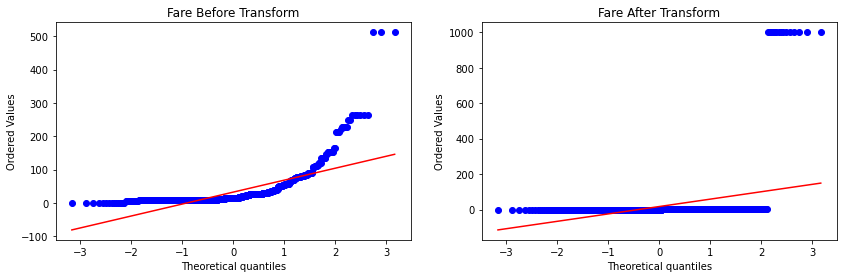

In [37]:
apply_transform(lambda x: 1/(x+0.001))